# **Load Data From Kaggle**

In [ ]:
def import_data_from_drive(id):
  !wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='{id} -O- \
  | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt && wget --content-disposition --load-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='{id}'&confirm='$(<confirm.txt)

In [ ]:
#https://drive.google.com/file/d/1w_XfBRKOXahYytCZjZq3dyK_6oPlyhSi/view?usp=sharing

In [ ]:
#from google.colab import files
#files.upload()
#-----------------------------#
%%time
#import json file


#import_data_from_drive('1w_XfBRKOXahYytCZjZq3dyK_6oPlyhSi')
import_data_from_drive('1-D3Kj_1FKK-E77OFc_f4Nl9HAhxI-WEK')#ethan

--2021-04-06 08:10:30--  https://docs.google.com/uc?export=download&id=1-D3Kj_1FKK-E77OFc_f4Nl9HAhxI-WEK
Resolving docs.google.com (docs.google.com)... 64.233.188.101, 64.233.188.139, 64.233.188.138, ...
Connecting to docs.google.com (docs.google.com)|64.233.188.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/33tf14ve0p2ik5dm47l3pctlbthtihmq/1617696600000/12626892632851982799/*/1-D3Kj_1FKK-E77OFc_f4Nl9HAhxI-WEK?e=download [following]
--2021-04-06 08:10:31--  https://doc-00-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/33tf14ve0p2ik5dm47l3pctlbthtihmq/1617696600000/12626892632851982799/*/1-D3Kj_1FKK-E77OFc_f4Nl9HAhxI-WEK?e=download
Resolving doc-00-94-docs.googleusercontent.com (doc-00-94-docs.googleusercontent.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connecting to doc-00-94-docs.googleusercontent.com (doc-00-94-

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c open-shopee-code-league-marketing-analytics

401 - Unauthorized


In [ ]:
!kaggle competitions download -c shopee-sentiment-analysis


401 - Unauthorized


In [ ]:
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip


Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')


In [ ]:
train_df.to_csv('/content/drive/My Drive/Colab Notebooks/Shopee Code League/#6 Sentiment Analysis/train.csv',index=False)
test_df.to_csv('/content/drive/My Drive/Colab Notebooks/Shopee Code League/#6 Sentiment Analysis/test.csv',index=False)


# **Set Up**

In [ ]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip
!unzip /content/users.csv.zip


Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/users.csv.zip
  inflating: users.csv               


In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
users = pd.read_csv('/content/users.csv')

# Train Set 欄位說明

- country_code: 國家代碼.

- grass_date: email被寄送的日期.

- user_id: 人的key值

- subject_line_length: 信件的長度

- last_[open\/ login\/ checkout]_day: User最後打開Email/登入/買過商品的日期

- open_count_last_[10\/ 30/60]_days:過去30天打開email的數量.

- login_count_last_[10\/ 30/60]_days:user在N天登入的次數.

- checkout_count_last_[10\/ 30/60]_days:User在過去幾天購買的次數.

- open_flag: Y 目標變數.



# **開秀**

In [ ]:
train['if_train']=1 ; test['if_train']=0
train['seq']=train.index;test['seq']=test.index

In [ ]:
total_set = pd.concat([train,test],axis=0)

total_set.groupby(['if_train']).apply(lambda x :len(x))

if_train
0    55970
1    73539
dtype: int64

In [ ]:
total_set['grass_date'] = pd.to_datetime(total_set['grass_date'], format='%Y-%m-%d %H:%M:%S')
total_set['grass_date']

0       2019-07-16 00:00:00+08:00
1       2019-07-16 00:00:00+08:00
2       2019-07-16 00:00:00+08:00
3       2019-07-16 00:00:00+08:00
4       2019-07-16 00:00:00+08:00
                   ...           
55965   2019-09-29 00:00:00+08:00
55966   2019-09-29 00:00:00+08:00
55967   2019-09-29 00:00:00+08:00
55968   2019-09-29 00:00:00+08:00
55969   2019-09-29 00:00:00+08:00
Name: grass_date, Length: 129509, dtype: datetime64[ns, pytz.FixedOffset(480)]

In [ ]:
import math
#cycle feature
total_set['month_Angle'] = (total_set['mon']-1)/12
total_set['month_ArcLen'] = (2*math.pi/12)*(total_set['mon']-1)#依弧長計算

#sin, tan transform: 角度越大,誤差越大 
total_set['month_ArcLen_sin'] = np.sin((2*math.pi/12)*(total_set['mon']-1))#依sin(弧長)計算
total_set['month_ArcLen_tan'] = np.tan((2*math.pi/12)*(total_set['mon']-1))#依tan(弧長)計算


In [ ]:
import math
#cycle feature
total_set['day_Angle'] = (total_set['day']-1)/30
total_set['day_ArcLen'] = (2*math.pi/12)*(total_set['day']-1)#依弧長計算

#sin, tan transform: 角度越大,誤差越大 
total_set['day_ArcLen_sin'] = np.sin((2*math.pi/30)*(total_set['day']-1))#依sin(弧長)計算
total_set['day_ArcLen_tan'] = np.tan((2*math.pi/30)*(total_set['day']-1))#依tan(弧長)計算


In [ ]:
total_set['row_id'].unique()

array([    0,     1,     2, ..., 73536, 73537, 73538])

In [ ]:
train.columns

Index(['country_code', 'grass_date', 'user_id', 'subject_line_length',
       'last_open_day', 'last_login_day', 'last_checkout_day',
       'open_count_last_10_days', 'open_count_last_30_days',
       'open_count_last_60_days', 'login_count_last_10_days',
       'login_count_last_30_days', 'login_count_last_60_days',
       'checkout_count_last_10_days', 'checkout_count_last_30_days',
       'checkout_count_last_60_days', 'open_flag', 'row_id', 'if_train',
       'seq'],
      dtype='object')

In [ ]:
#to num col
#last_open_day:Never open=0
#last_login_day:Never login=0
#last_login_day
#
#

In [ ]:
# feat_col = ['country_code', 'grass_date', 'user_id', 'subject_line_length',
#        'last_open_day', 'last_login_day', 'last_checkout_day',
#        'open_count_last_10_days', 'open_count_last_30_days',
#        'open_count_last_60_days', 'login_count_last_10_days',
#        'login_count_last_30_days', 'login_count_last_60_days',
#        'checkout_count_last_10_days', 'checkout_count_last_30_days',
#        'checkout_count_last_60_days', 'row_id']

In [ ]:
total_set = total_set.merge(users,on='user_id',how='left')

In [ ]:
to_str_col = ['open_count_last_10_days', 'open_count_last_30_days',
       'open_count_last_60_days', 'login_count_last_10_days',
       'login_count_last_30_days', 'login_count_last_60_days',
       'checkout_count_last_10_days', 'checkout_count_last_30_days',
       'checkout_count_last_60_days']

In [ ]:
for cols in to_str_col:
  total_set[cols+str('_s')]  = total_set[cols].astype(str)

In [ ]:
model_col = total_set.columns

# **陳天奇選手**

In [ ]:
train_set = total_set[total_set.if_train==1]
test_set = total_set[total_set.if_train==0]

In [ ]:
import xgboost as xgb

# specify your configurations as a dict
params = {
    'objective': 'binary:logistic', 

    'gamma': 1,
    'method':'gpu_hist',
    'silent': 0,
    'learning_rate':0.01,
    'max_depth':3,
    "lambda_l1":0.6,
    "lambda_l2":0.6,
    "subsample":0.9,
    "min_gain_to_split":0.0001,
    'verbose':1,
    'min_child_weight':2
}

In [ ]:
x_col = ['country_code',  'user_id', 'subject_line_length', 'open_count_last_10_days',
      'open_count_last_30_days', 'open_count_last_60_days', 'login_count_last_10_days', 'login_count_last_30_days', 'login_count_last_60_days', 
      'checkout_count_last_10_days', 'checkout_count_last_30_days', 'checkout_count_last_60_days', 'row_id', 
       'seq',  'mon' , 'day', 'month_Angle', 'month_ArcLen', 'month_ArcLen_sin','month_ArcLen_tan',
       'day_Angle','day_ArcLen','day_ArcLen_sin','day_ArcLen_tan'
    
              
       ]#, 'domain', 'open_count_last_10_days_s', 'open_count_last_30_days_s','grass_date''last_open_day', 'last_login_day', 'last_checkout_day',
       #'open_count_last_60_days_s', 'login_count_last_10_days_s', 'login_count_last_30_days_s', 'login_count_last_60_days_s', 'checkout_count_last_10_days_s', 
       #'checkout_count_last_30_days_s', 'checkout_count_last_60_days_s','attr_1', 'attr_2', 'attr_3', 'age']
print(x_col)

['country_code', 'user_id', 'subject_line_length', 'open_count_last_10_days', 'open_count_last_30_days', 'open_count_last_60_days', 'login_count_last_10_days', 'login_count_last_30_days', 'login_count_last_60_days', 'checkout_count_last_10_days', 'checkout_count_last_30_days', 'checkout_count_last_60_days', 'row_id', 'seq', 'mon', 'day', 'month_Angle', 'month_ArcLen', 'month_ArcLen_sin', 'month_ArcLen_tan', 'day_Angle', 'day_ArcLen', 'day_ArcLen_sin', 'day_ArcLen_tan']


In [ ]:
y_col = 'open_flag'

In [ ]:
from sklearn.model_selection import train_test_split

train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_set[x_col],train_set[y_col],stratify=train_set[y_col],test_size=0.1,random_state=2020)
train_paths.shape, valid_paths.shape, train_labels.shape, valid_labels.shape

((66185, 24), (7354, 24), (66185,), (7354,))

In [ ]:
dtrain = xgb.DMatrix(train_paths,label=train_labels)

In [ ]:
%%time

cv_xgb= xgb.cv(params,dtrain,
               num_boost_round=150000,
               early_stopping_rounds=500,
               nfold=3, show_stdv=True)

print(cv_xgb)

      train-error-mean  train-error-std  test-error-mean  test-error-std
0             0.119982         0.001059         0.120269        0.001742
1             0.119929         0.000990         0.120194        0.001782
2             0.119982         0.001059         0.120269        0.001742
3             0.119982         0.001059         0.120269        0.001742
4             0.119982         0.001059         0.120269        0.001742
...                ...              ...              ...             ...
1850          0.106943         0.000768         0.110599        0.001124
1851          0.106897         0.000767         0.110569        0.001112
1852          0.106882         0.000776         0.110554        0.001124
1853          0.106890         0.000766         0.110554        0.001158
1854          0.106897         0.000756         0.110539        0.001137

[1855 rows x 4 columns]
CPU times: user 8min 55s, sys: 701 ms, total: 8min 56s
Wall time: 4min 31s


In [ ]:
bst = xgb.train(params,dtrain,num_boost_round =cv_xgb.shape[0])

In [ ]:
dtest = xgb.DMatrix(test_set[x_col])

In [ ]:
y_pred = bst.predict(dtest)

In [ ]:
y_pred = np.where(y_pred>0.45,1,0)

In [ ]:
test_origin = pd.read_csv('/content/test.csv')

In [ ]:
test_origin.columns

Index(['country_code', 'grass_date', 'user_id', 'subject_line_length',
       'last_open_day', 'last_login_day', 'last_checkout_day',
       'open_count_last_10_days', 'open_count_last_30_days',
       'open_count_last_60_days', 'login_count_last_10_days',
       'login_count_last_30_days', 'login_count_last_60_days',
       'checkout_count_last_10_days', 'checkout_count_last_30_days',
       'checkout_count_last_60_days', 'row_id'],
      dtype='object')

In [ ]:
submit = pd.DataFrame({"row_id":test_origin['row_id'],
             "open_flag":y_pred })

In [ ]:
submit.groupby(['open_flag']).apply(lambda x :len(x) )

open_flag
0    50587
1     5383
dtype: int64

In [ ]:
submit.to_csv('sub_0803.csv',index=False)

In [ ]:
submit.head(3)

,row_id,open_flag
0,0,0
1,1,0
2,2,0


In [ ]:
!kaggle competitions submit -c open-shopee-code-league-marketing-analytics -f sub_ethan_osu.csv -m "Leak God"

100% 426k/426k [00:04<00:00, 90.5kB/s]
Successfully submitted to [Open] Shopee Code League - Marketing Analytics

# **黑魔法防禦術**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wHN5qQO48DZ9FuL_ap9GucOUU35OwyAjwvZO7-zuat1zndHQKknYf8
Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
test_base_old = pd.read_csv('/content/drive/My Drive/Python/Shopee Code League 2020/C8_Marketing/Dark Zone/SCL8_536.csv')
test_base_new = pd.read_csv('/content/drive/My Drive/Python/Shopee Code League 2020/C8_Marketing/Dark Zone/SCL8_528.csv')

In [ ]:
print('Num of 1 in old test data: '+ str(sum(test_base_old['open_flag'])))
print('Num of 1 in new test data: '+ str(sum(test_base_new['open_flag'])))

Num of 1 in old test data: 7915
Num of 1 in new test data: 8208


### **Ensemble:兩個檔案都有1才放**


In [ ]:
#30000以前猜的不穩定
index_old = set(test_base_old[(test_base_old.open_flag==1)].index)
index_new = set(test_base_new[(test_base_new.open_flag==1) & (test_base_new.index<30000)].index)

print('Count of index_old: '+str(len(index_old)) )
print('Count of index_new: '+str(len(index_new)) )

Count of index_old: 7915
Count of index_new: 3960


In [ ]:
#

idx = []
for num_place in range(len(test_base_old)):
  if num_place<30000:
    if num_place in index_old:
      idx.append(num_place)
  else:
    if (num_place in index_old) & (num_place in index_new):
      idx.append(num_place)

print('焦急的樣本數: '+ str(len(idx)) )
print(idx)

焦急的樣本數: 6838
[8, 10, 16, 18, 25, 37, 39, 60, 62, 67, 69, 74, 75, 79, 80, 87, 95, 103, 108, 116, 130, 134, 137, 141, 143, 145, 153, 157, 170, 174, 193, 207, 212, 218, 238, 243, 246, 262, 263, 270, 271, 276, 278, 279, 283, 300, 302, 304, 312, 315, 327, 330, 332, 339, 348, 371, 372, 381, 382, 394, 397, 401, 402, 412, 418, 428, 432, 443, 450, 468, 472, 473, 477, 478, 484, 485, 491, 503, 505, 529, 547, 548, 563, 567, 571, 591, 601, 609, 610, 616, 627, 652, 672, 684, 685, 689, 691, 702, 703, 709, 710, 714, 716, 739, 743, 744, 745, 749, 758, 760, 769, 774, 781, 783, 787, 796, 814, 815, 838, 848, 870, 890, 893, 894, 897, 907, 921, 945, 956, 962, 971, 979, 996, 1007, 1027, 1033, 1037, 1065, 1066, 1078, 1080, 1082, 1089, 1091, 1094, 1097, 1108, 1111, 1112, 1126, 1128, 1132, 1150, 1163, 1190, 1193, 1194, 1197, 1199, 1216, 1220, 1222, 1225, 1228, 1232, 1233, 1241, 1252, 1253, 1261, 1273, 1275, 1281, 1298, 1299, 1306, 1307, 1311, 1337, 1339, 1343, 1345, 1366, 1371, 1373, 1389, 1392, 1402, 1407, 141

In [ ]:
sum(test_base_old.loc[idx,:]['open_flag'])

6838

In [ ]:
ans=[]
op_l_old = list(test_base_old['open_flag'])
op_l_new = list(test_base_new['open_flag'])

for i in range(len(test_base_old)):
  if (op_l_old[i]==1) & (op_l_new[i]==1):
    ans.append(1)
  else:
    ans.append(0)

In [ ]:
sum(ans)
#last time:7915/0.536(0804)

7530

In [ ]:
test_base_old['open_flag']=ans
sum(test_base_old['open_flag'])

7530

In [ ]:
test_base_old.to_csv('lottery_0805.csv',index=False)

# **Leakage 抓抓**

In [ ]:
import_data_from_drive('1kAp0xMVgt3PsWJ2kTuDIGO2yBRzPUmzm')

--2020-08-05 01:48:16--  https://docs.google.com/uc?export=download&id=1kAp0xMVgt3PsWJ2kTuDIGO2yBRzPUmzm
Resolving docs.google.com (docs.google.com)... 74.125.68.113, 74.125.68.102, 74.125.68.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.68.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ajslmmomat8r12qk14ekldho0072j418/1596592050000/12626892632851982799/*/1kAp0xMVgt3PsWJ2kTuDIGO2yBRzPUmzm?e=download [following]
--2020-08-05 01:48:16--  https://doc-00-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ajslmmomat8r12qk14ekldho0072j418/1596592050000/12626892632851982799/*/1kAp0xMVgt3PsWJ2kTuDIGO2yBRzPUmzm?e=download
Resolving doc-00-94-docs.googleusercontent.com (doc-00-94-docs.googleusercontent.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting to doc-00-94-docs.googleusercontent.com (doc-00-94-docs.

In [ ]:
import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
import math
import scipy
import statistics as stat
import matplotlib.pyplot as plt

test_053=pd.read_csv('/content/SCL8_536.csv')

In [ ]:
test_1 = np.where(test_053['open_flag']==1)
test_1

(array([    8,    10,    16, ..., 55958, 55968, 55969]),)

In [ ]:
test_1_kde = list(range(test_053.shape[0]))

for j in range(6):
  for i in test_1:
      test_1_kde.extend(i)
#O(N)
test_1_kde.sort()
print(test_1_kde)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 11, 12, 13, 14, 15, 16, 16, 16, 16, 16, 16, 16, 17, 18, 18, 18, 18, 18, 18, 18, 19, 20, 21, 22, 23, 24, 25, 25, 25, 25, 25, 25, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 37, 37, 37, 37, 37, 37, 38, 39, 39, 39, 39, 39, 39, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 60, 60, 60, 60, 60, 60, 61, 62, 62, 62, 62, 62, 62, 62, 63, 64, 65, 66, 67, 67, 67, 67, 67, 67, 67, 68, 69, 69, 69, 69, 69, 69, 69, 70, 71, 72, 73, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 76, 77, 78, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 81, 82, 83, 84, 85, 86, 87, 87, 87, 87, 87, 87, 87, 88, 89, 90, 91, 92, 93, 94, 95, 95, 95, 95, 95, 95, 95, 96, 97, 98, 99, 100, 101, 102, 103, 103, 103, 103, 103, 103, 103, 104, 105, 106, 107, 108, 108, 108, 108, 108, 108, 108, 109, 110, 111, 112, 113, 114, 115, 116, 116, 116, 116, 116, 116, 116, 117, 118, 119, 120, 121, 122, 12

In [ ]:
#分開畫
test_1_low=[];test_1_high=[]

for num in test_1_kde:
  if num<30000:
    test_1_low.append(num)
  else :
    test_1_high.append(num)

print(test_1_low)
print(test_1_high)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 11, 12, 13, 14, 15, 16, 16, 16, 16, 16, 16, 16, 17, 18, 18, 18, 18, 18, 18, 18, 19, 20, 21, 22, 23, 24, 25, 25, 25, 25, 25, 25, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 37, 37, 37, 37, 37, 37, 38, 39, 39, 39, 39, 39, 39, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 60, 60, 60, 60, 60, 60, 61, 62, 62, 62, 62, 62, 62, 62, 63, 64, 65, 66, 67, 67, 67, 67, 67, 67, 67, 68, 69, 69, 69, 69, 69, 69, 69, 70, 71, 72, 73, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 76, 77, 78, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 81, 82, 83, 84, 85, 86, 87, 87, 87, 87, 87, 87, 87, 88, 89, 90, 91, 92, 93, 94, 95, 95, 95, 95, 95, 95, 95, 96, 97, 98, 99, 100, 101, 102, 103, 103, 103, 103, 103, 103, 103, 104, 105, 106, 107, 108, 108, 108, 108, 108, 108, 108, 109, 110, 111, 112, 113, 114, 115, 116, 116, 116, 116, 116, 116, 116, 117, 118, 119, 120, 121, 122, 12

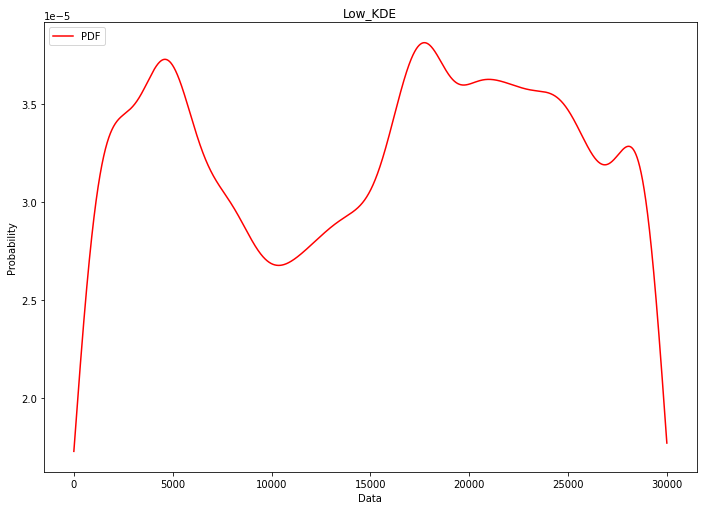

In [ ]:
#Kernel Show Time
import scipy.stats as st
plt.rc('figure', figsize=(11.69,8.27))
kde = st.gaussian_kde(test_1_low)

plt.plot(test_1_low, kde.pdf(test_1_low),'r',label="PDF")#==1

plt.legend(loc="upper left")
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title("Low_KDE");

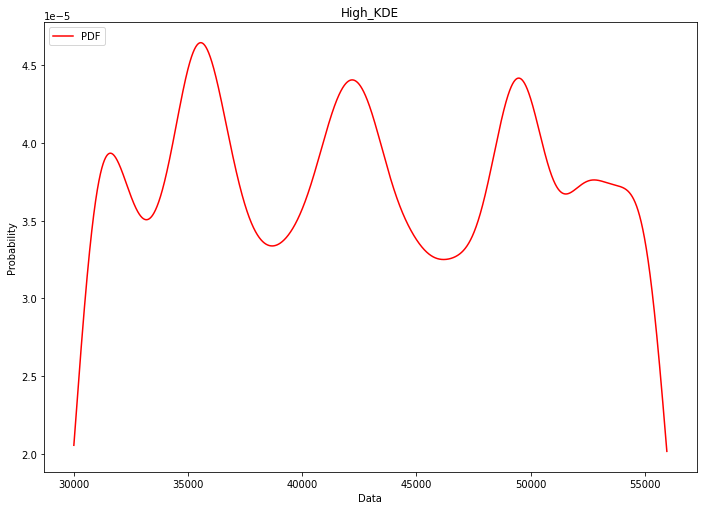

In [ ]:
#Kernel Show Time
import scipy.stats as st
plt.rc('figure', figsize=(11.69,8.27))
kde = st.gaussian_kde(test_1_high)

plt.plot(test_1_high, kde.pdf(test_1_high),'r',label="PDF")#==1

plt.legend(loc="upper left")
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title("High_KDE");

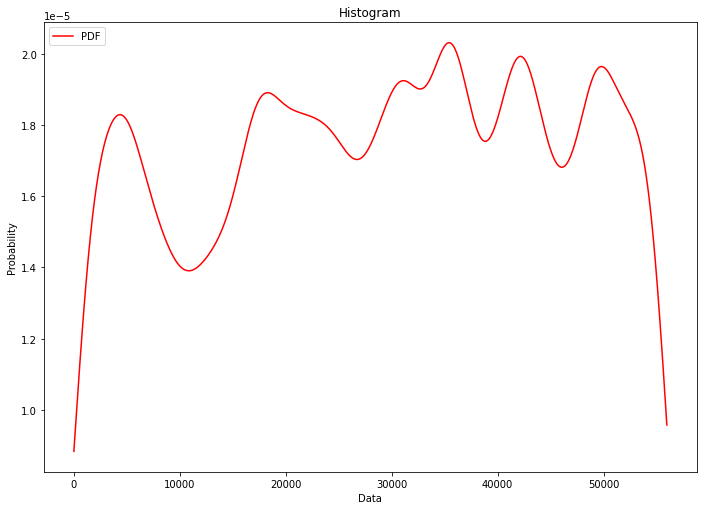

In [ ]:
#Kernel Show Time
import scipy.stats as st
plt.rc('figure', figsize=(11.69,8.27))
kde = st.gaussian_kde(test_1_kde)

plt.plot(test_1_kde, kde.pdf(test_1_kde),'r',label="PDF")#==1

plt.legend(loc="upper left")
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title("Histogram");